In [3]:
import numpy as np
import random 
from collections import defaultdict
import matplotlib.pyplot as plt

In [12]:
class Bandit:
    
    def __init__(self, k):
        """
        k: number of bandits 
        """
        self.k = k
        self.mean_sd_list = [] # Storing mean and sf of each bandit
        
        max_mean = 0
        self.max_i = 0
        
        for i in range(k):
            mean = random.uniform(0, 10)
            sigma = random.uniform(0, 1)
            self.mean_sd_list.append((mean, sigma))
            
            if mean > max_mean:
                max_mean = mean
                self.max_i = i
        
    def generate_reward(self, i):
        mu, sigma = self.mean_sd_list[i]
        return np.random.normal(mu, sigma)
    
    def generate_optimum_reward(self):
        return self.generate_reward(self.max_i)

In [5]:
class Solver(object):
    
    def __init__(self, bandit):
        """
        bandit(object of class Bandit) to solve
        """
        
        self.bandit = bandit
        
        self.counts = [0] * self.bandit.k
        self.actions = []
        self.cumulative_regret = 0
        self.cumulative_regret_list = []
        self.cumulative_reward = 0
        self.avg_reward_list = []
    
    def update_regret(self, r):
        self.cumulative_regret += self.bandit.generate_optimum_reward() - r
        self.cumulative_regret_list.append(self.cumulative_regret)
    
    def update_reward(self, r):
        self.cumulative_reward += r
        self.t = np.sum(self.counts)
        self.avg_reward_list.append(self.cumulative_reward / self.t)
        
    def run_one_step(self):
        pass
    
    def run(self, num_steps):
        
        for _ in range(num_steps):
            i, r = self.run_one_step()
            
            self.counts[i] += 1 
            
            self.update_regret(r)
            self.update_reward(r)
            self.actions.append(i)

    # Functions to average results over num_avg times        
    # Reset parameters
    def reinit(self):
        self.counts = [0] * self.bandit.k
        self.actions = []
        self.cumulative_regret = 0
        self.cumulative_regret_list = []
        self.cumulative_reward = 0
        self.avg_reward_list = []
        
    def avg_run(self, num_steps, num_avg):
        avg_list = [0] * num_steps
        for _ in range(num_avg):
            self.reinit()
            self.run(num_steps)
            for i in range(num_steps):
                avg_list[i] += self.avg_reward_list[i]
        
        avg_list = [x/num_avg for x in avg_list]
        return avg_list

In [10]:
class EpsilonGreedy(Solver):
    
    def __init__(self, bandit, epsilon, time_variant_epsilon, init_trials):
        super().__init__(bandit)
        self.bandit = bandit
        self.epsilon = epsilon
        self.time_variant_epsilon = time_variant_epsilon
        self.mean_estimate = [0] * self.bandit.k
        
        self.set_inital_estimate(init_trials)
#         print("Initial estimate = ", self.mean_estimate)
    
    def set_inital_estimate(self, trials):
        for _ in range(trials):
            for i in range(self.bandit.k):
                r = self.bandit.generate_reward(i)
                self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

    def run_one_step(self):
        # Exploration
        if np.random.random() < self.epsilon:
            i = np.random.randint(0, self.bandit.k)
        # Exploitation
        else:
            # Pick the one with max probabilities
            i = max(range(self.bandit.k), key = lambda x: self.mean_estimate[x])
        
        r = self.bandit.generate_reward(i)
        self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)
        
        if self.time_variant_epsilon:
            t = np.sum(self.counts) + 1
            self.epsilon = self.epsilon/t
        
        return i, r

In [14]:
def main(k, n):
    """
    k = number of bandits
    n = time steps
    """
    
    # defining object of class Bandit 
    bandit = Bandit(k) 
    print("Guassian distribution of bandits = \n", bandit.mean_sd_list)
    
    solvers = [EpsilonGreedy(bandit, epsilon = 0.0, init_trials = 1, time_variant_epsilon = False), 
          EpsilonGreedy(bandit, epsilon = 0.01, init_trials = 1, time_variant_epsilon = False), 
          EpsilonGreedy(bandit, epsilon = 0.1, init_trials = 1, time_variant_epsilon = True), 
          EpsilonGreedy(bandit, epsilon = 0.2, init_trials = 1, time_variant_epsilon = True)]
    
    # Solve for each of the object
    for s in solvers:
        s.run(n)
    
    # Plot average reward for each solver
    plt.figure(figsize = (10, 8))
    colors = ['k', 'b', 'r', 'y']
    labels = ['Epsilon = 0.0', 'Epsilon = 0.01', 'Epsilon = 0.1 (time variant)', 'Epsilon = 0.2 (time variant)']
    i = 0
    for s in solvers:
        plt.plot(s.avg_reward_list, color = colors[i], label = labels[i])
        i += 1

    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.title("Average Reward vs steps for {} bandits".format(k))
    plt.show()
    
    
    # Plot cumulative regret for each solver
    plt.figure(figsize = (10, 8))
    i = 0
    for s in solvers:
        plt.plot(s.cumulative_regret_list, color = colors[i], label = labels[i])
        i += 1

    plt.xlabel("Steps")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.title("Cumulative regret vs steps for {} bandits".format(k))
    plt.show()

Guassian distribution of bandits = 
 [(5.201917628475668, 0.38330133524458865), (6.064599336587691, 0.20446152654809635), (0.33269753864892837, 0.8352331089769185), (1.5999735654183889, 0.8273634005105471), (7.995182898645792, 0.48964470757321177), (5.796400732844887, 0.7392093534456109), (7.853463348117856, 0.8483926322191353), (6.07191240335979, 0.5780193459273227), (3.647887430680301, 0.6298018537987515), (2.0783562282965553, 0.9175867081080611)]


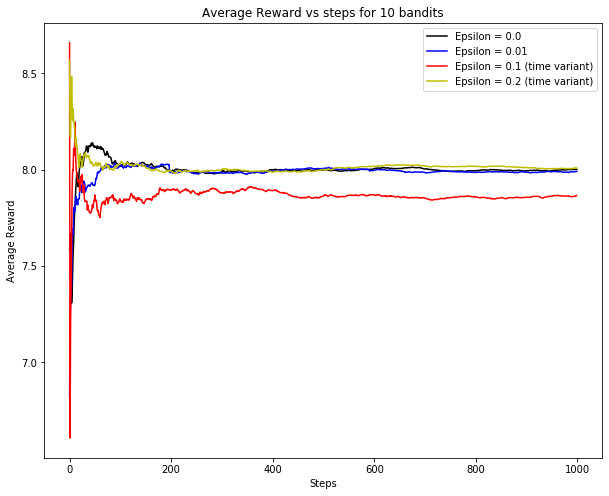

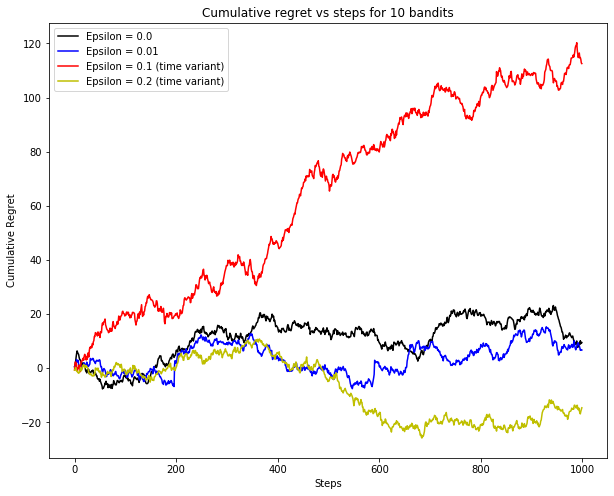

In [15]:
main(k = 10, n = 10000)

### Taking average over 2000 steps

Guassian distribution of bandits = 
 [(2.611436570481459, 0.3218365823960678), (0.7207133102562624, 1.9567892040087644)]


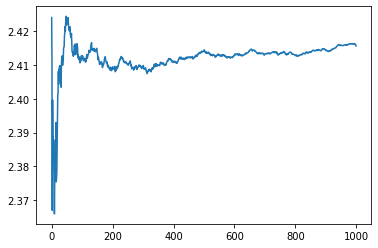

In [146]:
bandit = Bandit(k)

print("Guassian distribution of bandits = \n", bandit.mean_sd_list)

epsilon_greedy_solver = EpsilonGreedy(bandit, epsilon = 0.2, init_trials = 1, time_variant_epsilon = False)
l = epsilon_greedy_solver.avg_run(n, 100)

# plt.plot(epsilon_greedy_solver.avg_reward_list)
plt.plot(l)

In [16]:
k = 5
n = 10000
avg_over = 100
bandit = Bandit(k)

print("Guassian distribution of bandits = \n", bandit.mean_sd_list)

colors = ['k', 'b', 'r', 'y']
labels = ['Epsilon = 0.0', 'Epsilon = 0.01', 'Epsilon = 0.1 (time variant)', 'Epsilon = 0.2 (time variant)']

solvers = [EpsilonGreedy(bandit, epsilon = 0.0, init_trials = 1, time_variant_epsilon = False), 
          EpsilonGreedy(bandit, epsilon = 0.01, init_trials = 1, time_variant_epsilon = False), 
          EpsilonGreedy(bandit, epsilon = 0.1, init_trials = 1, time_variant_epsilon = True), 
          EpsilonGreedy(bandit, epsilon = 0.2, init_trials = 1, time_variant_epsilon = True)]

Guassian distribution of bandits = 
 [(9.77938723187151, 0.9312481498717867), (1.5418687889204208, 0.5695604403171018), (3.853742284338132, 0.8613495315013096), (3.4877691482584594, 0.1313957401928726), (9.875579834779145, 0.7778426748065486)]


In [17]:
avg_list = []
for s in solvers:
    l = s.avg_run(n, avg_over)
    avg_list.append(l)

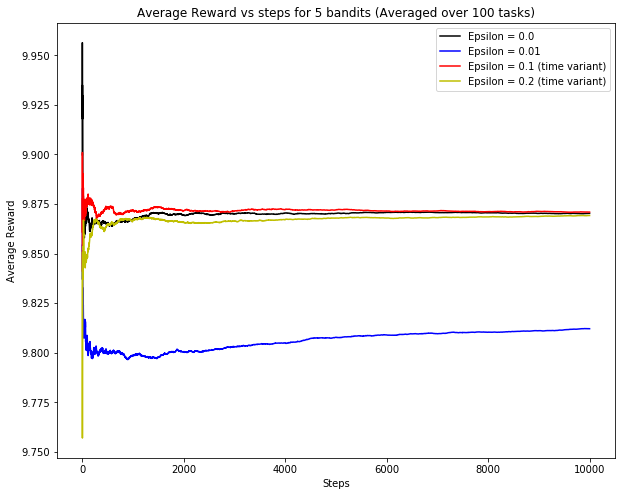

In [18]:
plt.figure(figsize = (10, 8))
for i, l in enumerate(avg_list):
    plt.plot(l, color = colors[i], label = labels[i])
    
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs steps for {} bandits (Averaged over {} tasks)".format(k, avg_over))
plt.show()

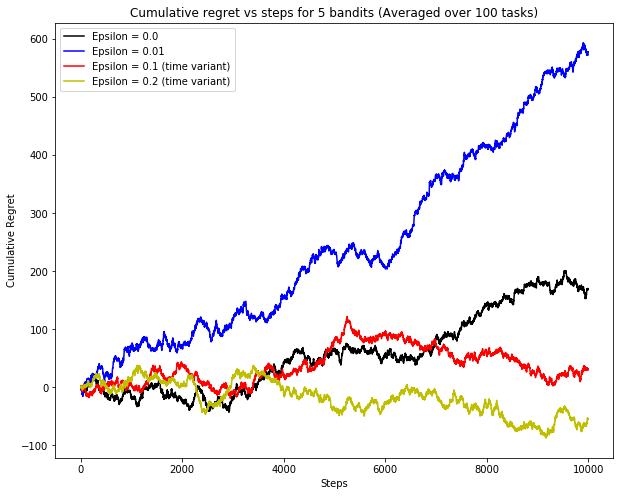

In [21]:
plt.figure(figsize = (10, 8))
i = 0
for s in solvers:
    plt.plot(s.cumulative_regret_list, color = colors[i], label = labels[i])
    i += 1
    
plt.xlabel("Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Cumulative regret vs steps for {} bandits (Averaged over {} tasks)".format(k, avg_over))
plt.show()